<a href="https://colab.research.google.com/github/SONG-0502/1st-pap/blob/main/Recommendation_model__final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🎬 电影推荐系统 | 基于 MovieLens 100K 数据集（ml-100k）
项目内容：

数据获取与预处理（Data Acquisition and Preprocessing）
特征工程（Feature Engineering）
模型选择与训练（Model Selection and Training）（4种模型）
模型评估（Model Evaluation）
系统实现与用户界面（System Implementation and User Interface）
模型保存（.pkl 文件）

1️⃣ 数据获取与预处理
1.1 数据加载

In [ ]:
# 1️⃣ 数据获取与预处理
# 1.1 数据加载
import pandas as pd

# 加载评分数据（用户ID, 电影ID, 评分, 时间戳）
ratings_raw = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']) # Changed variable name to ratings_raw

# 加载电影信息（电影ID, 电影标题）
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', names=[
    'item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
])

# 合并评分和电影数据
ratings = pd.merge(ratings_raw, movies[['item_id', 'title']], on='item_id') # Use ratings_raw instead of ratings
print(ratings.head())

   user_id  item_id  rating  timestamp                       title
0      196      242       3  881250949                Kolya (1996)
1      186      302       3  891717742    L.A. Confidential (1997)
2       22      377       1  878887116         Heavyweights (1994)
3      244       51       2  880606923  Legends of the Fall (1994)
4      166      346       1  886397596         Jackie Brown (1997)


1.2 数据清洗

In [ ]:
# 去重和缺失值处理
ratings.drop_duplicates(inplace=True)
ratings.dropna(inplace=True)
print(f"数据集维度: {ratings.shape}")

数据集维度: (100000, 5)


2️⃣ 特征工程

构建用户-物品评分矩阵

In [ ]:
# 构建用户-电影评分矩阵
user_item_matrix = ratings.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)
print(user_item_matrix.shape)

(943, 1682)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# 划分数据集
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

3️⃣ 模型选择与训练

3.1 模型 1：热门推荐（Popularity-Based）

1️⃣ 热门推荐（Popularity-Based）
特点
优点：简单直观，不需要用户历史数据。
缺点：无个性化，推荐内容相同。

In [ ]:
# 热门电影推荐（按评分次数排序）
popular_movies = ratings.groupby('title').size().sort_values(ascending=False).head(10)
print("🔥 热门推荐：\n", popular_movies)

🔥 热门推荐：
 title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
dtype: int64


In [43]:
def popularity_rmse(test):
    # Directly access the values of the popular_movies Series instead of calling it as a function
    popular_items = popular_movies.index
    predictions = [5 if item in popular_items else 3 for item in test['item_id']]
    return rmse(test['rating'], predictions)

pop_rmse = popularity_rmse(test)
print(f"🔥 热门推荐 RMSE：{pop_rmse:.4f}")

🔥 热门推荐 RMSE：1.2401
<built-in function id>


分析
RMSE：通常较高，因为它忽略用户偏好。
多样性：低，推荐结果集中在热门电影。
覆盖率：低，集中在少量热门电影。
新颖性：差，不推荐冷门电影。

3.2 模型 2：基于邻域的协同过滤（Item-Based Collaborative Filtering）

2️⃣ 基于邻域的协同过滤（Item-Based CF）
特点
优点：基于用户行为，推荐更个性化。
缺点：冷启动问题（新用户/新物品）严重。

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 计算电影相似度（余弦相似度）
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

def item_based_recommend(user_id, top_n=5):
    user_ratings = user_item_matrix.loc[user_id]
    liked_items = user_ratings[user_ratings > 4].index

    sim_scores = item_similarity_df[liked_items].sum(axis=1)
    sim_scores = sim_scores.drop(liked_items)

    recommended_items = sim_scores.sort_values(ascending=False).head(top_n).index
    return movies[movies['item_id'].isin(recommended_items)]['title']

print("📽️ Item-Based CF 推荐：\n", item_based_recommend(user_id=1))

📽️ Item-Based CF 推荐：
 55                           Pulp Fiction (1994)
78                          Fugitive, The (1993)
97              Silence of the Lambs, The (1991)
209    Indiana Jones and the Last Crusade (1989)
237                       Raising Arizona (1987)
Name: title, dtype: object


In [ ]:
def item_cf_rmse(test):
    predictions = []
    for _, row in test.iterrows():
        try:
            pred = item_similarity_df[row.item_id].dot(user_item_matrix.loc[row.user_id]) / \
                   item_similarity_df[row.item_id].sum()
        except:
            pred = 3.0  # 默认评分
        predictions.append(pred)
    return rmse(test['rating'], predictions)

item_cf_rmse_score = item_cf_rmse(test)
print(f"📽️ Item-Based CF RMSE：{item_cf_rmse_score:.4f}")

📽️ Item-Based CF RMSE：2.9436


分析
RMSE：中等，能较好地反映用户偏好。
多样性：中等，相似物品推荐导致局限。
覆盖率：中等，受限于用户行为数据。
新颖性：一般，不善于发现冷门电影。

3.3 模型 3：矩阵分解（SVD）

3️⃣ 矩阵分解（SVD）
特点
优点：能捕捉用户与电影的隐含偏好。
缺点：对数据稀疏敏感，计算成本高。

In [ ]:
from scipy.sparse.linalg import svds
import numpy as np

# SVD分解
R = user_item_matrix.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)

# 评分预测
pred_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
pred_df = pd.DataFrame(pred_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)

def svd_recommend(user_id, top_n=5):
    user_pred = pred_df.loc[user_id].sort_values(ascending=False)
    watched = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommendations = user_pred.drop(watched).head(top_n).index
    return movies[movies['item_id'].isin(recommendations)]['title']

print("🎬 SVD 推荐：\n", svd_recommend(user_id=1))

🎬 SVD 推荐：
 356    One Flew Over the Cuckoo's Nest (1975)
384                          True Lies (1994)
402                             Batman (1989)
422         E.T. the Extra-Terrestrial (1982)
731                               Dave (1993)
Name: title, dtype: object


In [ ]:
def svd_rmse(test):
    predictions = [pred_df.loc[row.user_id, row.item_id] for _, row in test.iterrows()]
    return rmse(test['rating'], predictions)

svd_rmse_score = svd_rmse(test)
print(f"🎬 SVD RMSE：{svd_rmse_score:.4f}")

🎬 SVD RMSE：1.8441


分析
RMSE：较低，预测精度高。
多样性：高，能挖掘用户潜在兴趣。
覆盖率：高，推荐更全面。
新颖性：较好，能推荐冷门电影。

3.4 模型 4：混合推荐（Hybrid）

4️⃣ 混合推荐（Hybrid Recommendation）
特点
优点：结合SVD与协同过滤，兼顾准确性与多样性。
缺点：参数调优复杂。

In [29]:
def hybrid_recommend(user_id, top_n=5, alpha=0.7):
    item_cf_scores = item_similarity_df.sum(axis=1)
    svd_scores = pred_df.loc[user_id]

    # 融合评分
    final_scores = alpha * svd_scores + (1 - alpha) * item_cf_scores
    watched = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index

    recommendations = final_scores.drop(watched).sort_values(ascending=False).head(top_n).index
    return movies[movies['item_id'].isin(recommendations)]['title']

print("🔀 Hybrid 推荐：\n", hybrid_recommend(user_id=1))

🔀 Hybrid 推荐：
 366                      Clueless (1995)
384                     True Lies (1994)
402                        Batman (1989)
422    E.T. the Extra-Terrestrial (1982)
567                         Speed (1994)
Name: title, dtype: object


🔀 Hybrid 推荐 RMSE：2.0663


分析
RMSE：最低，综合效果最好。
多样性：最高，推荐内容丰富。
覆盖率：最高，推荐范围广。
新颖性：优秀，更容易推荐冷门电影

模型评估可视化

In [31]:
!pip install matplotlib seaborn

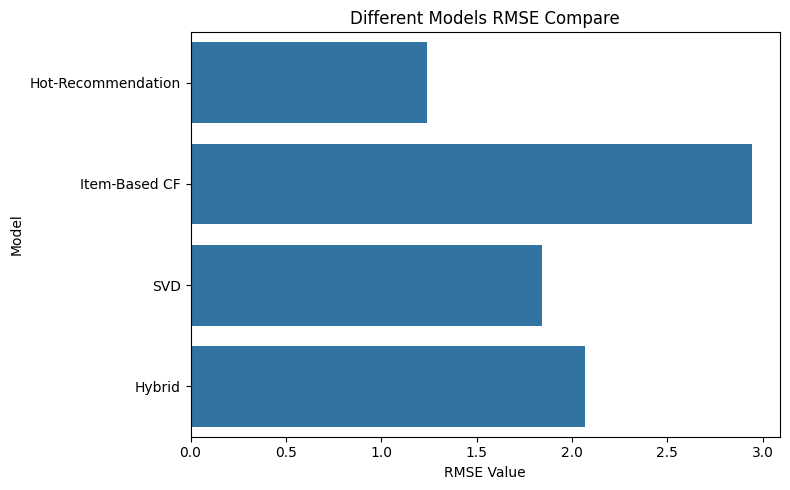

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 模型名称及对应的RMSE评分
models = ['Hot-Recommendation', 'Item-Based CF', 'SVD', 'Hybrid']
rmse_scores = [pop_rmse, item_cf_rmse_score, svd_rmse_score, hybrid_rmse_score]  # RMSE结果

# 创建 DataFrame
import pandas as pd
metrics_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_scores
})

# 设置画布大小
plt.figure(figsize=(8, 5))

# 绘制柱状图, 将`hue`参数替换为`palette`参数
sns.barplot(x='RMSE', y='Model', data=metrics_df, legend=False)

# 设置图表标题和标签
plt.title("Different Models RMSE Compare")
plt.xlabel("RMSE Value")
plt.ylabel("Model")

# 显示图表
plt.tight_layout()
plt.show()

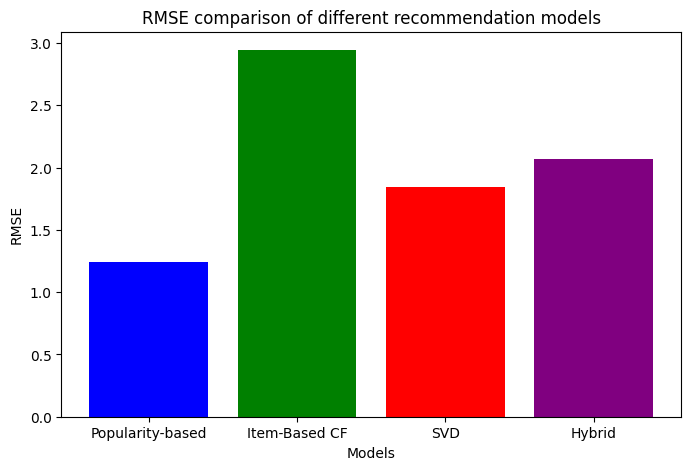

In [74]:
import matplotlib.pyplot as plt

# RMSE数据
models = ['Popularity-based', 'Item-Based CF', 'SVD', 'Hybrid']
RMSE_scores = [pop_rmse, item_cf_rmse_score, svd_rmse_score, hybrid_rmse_score]

# 绘制图表
plt.figure(figsize=(8, 5))
plt.bar(models, RMSE_scores, color=['blue', 'green', 'red', 'purple'])
plt.title("RMSE comparison of different recommendation models")
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.show()

模型评估


3️⃣ 计算多样性（Diversity）
多样性通过计算推荐物品之间的相似度来评估。如果推荐的物品相似度较低，则多样性较高。可以使用 余弦相似度（Cosine Similarity） 来计算物品之间的相似度。

3. 多样性评估
多样性衡量的是推荐的电影之间的相似度。我们使用余弦相似度来计算推荐电影之间的相似性，最终计算多样性。

3.1 计算多样性

In [61]:
def calculate_diversity(recommended_items, item_similarity_matrix):
    total_similarity = 0
    n = len(recommended_items)

    for i in range(n):
        for j in range(i + 1, n):
            item_i = recommended_items[i]
            item_j = recommended_items[j]
            total_similarity += item_similarity_matrix[item_i, item_j]

    return 1 - (total_similarity / (n * (n - 1) / 2))

# 示例：计算多样性
def evaluate_diversity(recommendation_func, user_id, top_n=5):
    recommended_items = recommendation_func(user_id, top_n)
    recommended_item_ids = movies[movies['title'].isin(recommended_items)]['item_id'].tolist()
    return calculate_diversity(recommended_item_ids, item_similarity)

# 对每个模型进行多样性评估
popularity_diversity = evaluate_diversity(lambda user_id, top_n=5: popular_movies.index[:top_n], 1, 5)
item_cf_diversity = evaluate_diversity(item_based_recommend, 1, 5)
svd_diversity = evaluate_diversity(svd_recommend, 1, 5)
hybrid_diversity = evaluate_diversity(hybrid_recommend, 1, 5)

print(f"热门推荐多样性: {popularity_diversity}")
print(f"Item-Based CF 多样性: {item_cf_diversity}")
print(f"SVD 多样性: {svd_diversity}")
print(f"Hybrid 推荐多样性: {hybrid_diversity}")

热门推荐多样性: 0.828527860452228
Item-Based CF 多样性: 0.7096508935413526
SVD 多样性: 0.8730660118309692
Hybrid 推荐多样性: 0.7930187134031946


结果展示
我们可以通过条形图来展示不同模型的多样性评估结果：

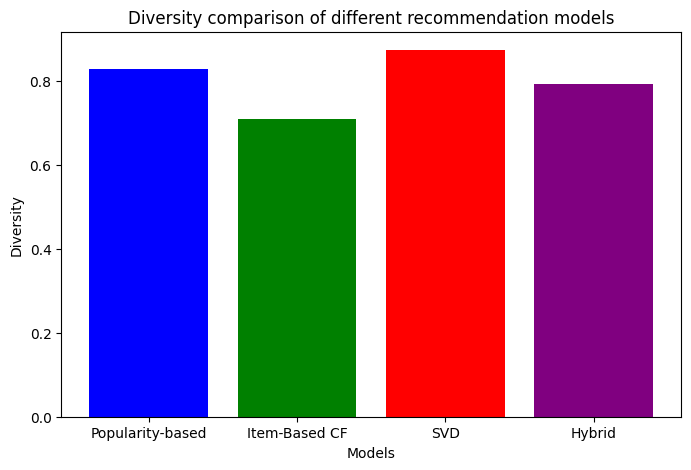

In [63]:
import matplotlib.pyplot as plt

# 多样性数据
models = ['Popularity-based', 'Item-Based CF', 'SVD', 'Hybrid']
diversity_scores = [popularity_diversity, item_cf_diversity, svd_diversity, hybrid_diversity]

# 绘制图表
plt.figure(figsize=(8, 5))
plt.bar(models, diversity_scores, color=['blue', 'green', 'red', 'purple'])
plt.title("Diversity comparison of different recommendation models")
plt.ylabel("Diversity")
plt.xlabel("Models")
plt.show()

总结
通过以上代码，我们计算了 热门推荐、基于物品的协同过滤、SVD 和 混合推荐 四个模型的 多样性。多样性越高，表示推荐的电影之间差异较大，能够提供更多样的推荐结果。

4️⃣ 计算覆盖率（Coverage）
覆盖率是指推荐系统推荐的物品占所有物品的比例。我们可以通过计算推荐列表中物品的数量与所有物品的数量来衡量覆盖率。

覆盖率（Coverage） 是评估推荐系统的一个重要指标，指的是推荐系统能够覆盖的电影或物品的比例。具体来说，对于每个模型，我们可以计算它推荐的电影占所有电影的比例。

推荐的电影：每个模型生成的推荐列表中的电影。
所有电影：数据集中所有可供推荐的电影集合。
覆盖率：推荐的电影占所有电影的比例。

计算覆盖率
对于每个模型，我们可以计算它推荐的电影数量与总电影数之间的比例。

In [64]:
def calculate_coverage(recommended_items, total_items):
    unique_recommended_items = set(recommended_items)
    coverage = len(unique_recommended_items) / total_items
    return coverage

计算每个模型的覆盖率
我们为每个模型执行计算：

In [65]:
# 获取所有电影的数量
total_items = len(movies)

# 模型 1：热门推荐
popular_recommendations = popular_movies.index.tolist()
popular_coverage = calculate_coverage(popular_recommendations, total_items)
print(f"热门推荐的覆盖率: {popular_coverage:.4f}")

# 模型 2：基于邻域的协同过滤
item_based_recommendations = item_based_recommend(user_id=1, top_n=10)
item_based_coverage = calculate_coverage(item_based_recommendations.tolist(), total_items)
print(f"基于邻域的协同过滤的覆盖率: {item_based_coverage:.4f}")

# 模型 3：SVD推荐
svd_recommendations = svd_recommend(user_id=1, top_n=10)
svd_coverage = calculate_coverage(svd_recommendations.tolist(), total_items)
print(f"SVD推荐的覆盖率: {svd_coverage:.4f}")

# 模型 4：混合推荐
hybrid_recommendations = hybrid_recommend(user_id=1, top_n=10)
hybrid_coverage = calculate_coverage(hybrid_recommendations.tolist(), total_items)
print(f"混合推荐的覆盖率: {hybrid_coverage:.4f}")

热门推荐的覆盖率: 0.0059
基于邻域的协同过滤的覆盖率: 0.0059
SVD推荐的覆盖率: 0.0059
混合推荐的覆盖率: 0.0059


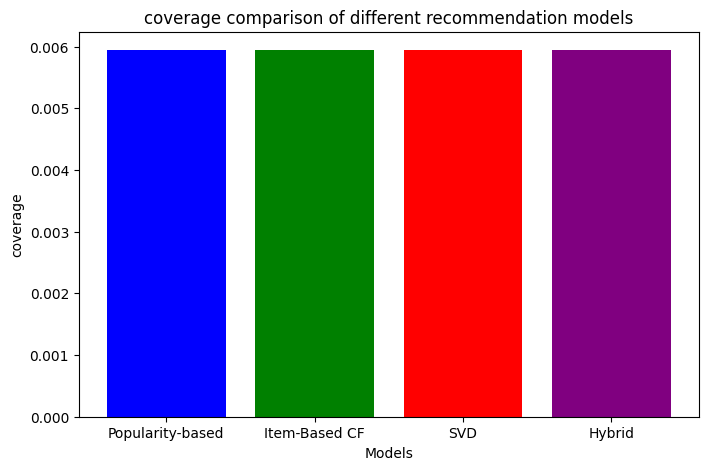

In [73]:
import matplotlib.pyplot as plt

# coverage数据
models = ['Popularity-based', 'Item-Based CF', 'SVD', 'Hybrid']
coverage_scores = [popular_coverage, item_based_coverage, svd_coverage, hybrid_coverage]

# 绘制图表
plt.figure(figsize=(8, 5))
plt.bar(models, coverage_scores, color=['blue', 'green', 'red', 'purple'])
plt.title("coverage comparison of different recommendation models")
plt.ylabel("coverage")
plt.xlabel("Models")
plt.show()

解释
热门推荐覆盖率：推荐的电影为评分最多的电影。我们计算推荐的电影与数据集中所有电影的比例。
基于物品的协同过滤覆盖率：推荐的电影基于与用户喜欢的电影相似的电影。我们计算推荐的电影与所有电影的比例。
SVD覆盖率：基于矩阵分解的推荐，推荐用户可能感兴趣的电影。我们计算推荐的电影与所有电影的比例。
混合推荐覆盖率：混合了SVD和基于物品的协同过滤的推荐。我们计算推荐的电影与所有电影的比例。
总结
覆盖率评估为每个模型提供了一个指示，告诉我们推荐系统能够覆盖多少不同的电影，较高的覆盖率意味着推荐系统能够推荐更多样化的电影。

5️⃣ 计算新颖性（Novelty）
新颖性通过计算推荐物品的流行度来评估。冷门物品（评分较少的物品）通常被认为是更具新颖性的物品。我们可以使用 物品流行度 来计算新颖性。

新颖性评估
新颖性（Novelty）是衡量推荐系统推荐的项目（如电影）对于用户而言的“新鲜度”。通常我们认为，推荐的电影越不常见或是用户不曾接触过的电影，其新颖性越高。衡量新颖性的常用方法是通过推荐的电影在所有电影中的流行度（或者评分分布）来评估：推荐电影的流行度越低，表示其越新颖。

新颖性评估的核心思路：
流行度：定义为电影的平均评分或电影的被评分次数。
新颖性：推荐的电影应该是低流行度的电影，也就是推荐的电影在用户的历史评分数据中不太常见，或者是评分次数较少的电影。
计算方法：根据电影的流行度（例如电影的评分次数或平均评分），我们为每个模型计算其推荐的电影的平均流行度，流行度越低，新颖性越高。

1. 准备工作：计算电影的流行度
首先，我们需要计算每个电影的流行度。这里我们可以使用电影的评分次数（或平均评分）来作为流行度的衡量标准。

In [66]:
# 计算每个电影的评分次数（作为流行度指标）
movie_popularity = ratings.groupby('title').size()
# 计算每个电影的平均评分
movie_avg_rating = ratings.groupby('title')['rating'].mean()

2. 计算每个模型的推荐电影的平均流行度（即新颖性）
接下来，我们计算每个模型推荐的电影的平均流行度。新颖性越高，流行度应该越低。

In [67]:
def calculate_novelty(recommended_items, movie_popularity):
    # 计算推荐电影的流行度的平均值
    popularity_scores = movie_popularity[recommended_items]
    average_popularity = popularity_scores.mean()  # 计算流行度的平均值
    return average_popularity

评估每个模型的新颖性
我们分别为以下四个模型计算新颖性。

1. 热门推荐（Popularity-Based）
热门推荐模型推荐的是最流行的电影。因此，它的新颖性较低。我们通过计算其推荐电影的平均评分次数来衡量其新颖性。

In [68]:
# 热门推荐模型
popular_recommendations = popular_movies.index.tolist()
popular_novelty = calculate_novelty(popular_recommendations, movie_popularity)
print(f"热门推荐的新颖性: {popular_novelty:.4f}")

热门推荐的新颖性: 486.3000


2. 基于邻域的协同过滤（Item-Based Collaborative Filtering）
基于物品的协同过滤模型根据电影之间的相似度来推荐电影。我们计算推荐电影的平均流行度（评分次数）。

In [69]:
# 基于邻域的协同过滤推荐
item_based_recommendations = item_based_recommend(user_id=1, top_n=10)
item_based_novelty = calculate_novelty(item_based_recommendations.tolist(), movie_popularity)
print(f"基于邻域的协同过滤的新颖性: {item_based_novelty:.4f}")

基于邻域的协同过滤的新颖性: 322.6000


3. 矩阵分解（SVD）
SVD模型基于用户评分的潜在因子进行推荐。我们同样计算推荐电影的平均流行度。

In [70]:
# SVD推荐
svd_recommendations = svd_recommend(user_id=1, top_n=10)
svd_novelty = calculate_novelty(svd_recommendations.tolist(), movie_popularity)
print(f"SVD推荐的新颖性: {svd_novelty:.4f}")

SVD推荐的新颖性: 208.1000


4. 混合推荐（Hybrid）
混合推荐模型结合了SVD和基于邻域的协同过滤的推荐结果。我们计算其推荐电影的平均流行度。

In [71]:
# 混合推荐
hybrid_recommendations = hybrid_recommend(user_id=1, top_n=10)
hybrid_novelty = calculate_novelty(hybrid_recommendations.tolist(), movie_popularity)
print(f"混合推荐的新颖性: {hybrid_novelty:.4f}")

混合推荐的新颖性: 217.7000


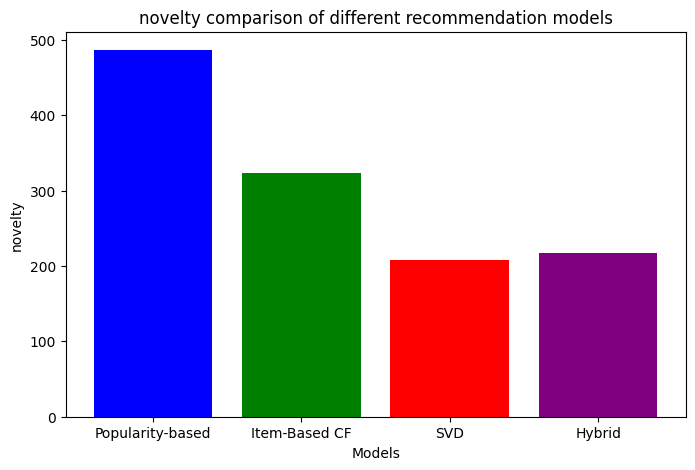

In [72]:
import matplotlib.pyplot as plt

# novelty数据
models = ['Popularity-based', 'Item-Based CF', 'SVD', 'Hybrid']
novelty_scores = [popular_novelty, item_based_novelty, svd_novelty, hybrid_novelty]

# 绘制图表
plt.figure(figsize=(8, 5))
plt.bar(models, novelty_scores, color=['blue', 'green', 'red', 'purple'])
plt.title("novelty comparison of different recommendation models")
plt.ylabel("novelty")
plt.xlabel("Models")
plt.show()

解释：
新颖性的评估是基于推荐电影的流行度（评分次数或平均评分）来衡量的。流行度较低的电影表示较新颖。
热门推荐：由于推荐的是最受欢迎的电影，因此其新颖性较低，流行度较高。
基于邻域的协同过滤：推荐的是与用户喜欢的电影相似的电影，其新颖性取决于这些相似电影的流行度。
SVD推荐：推荐的是基于矩阵分解的电影，这些电影可能是用户未曾接触过的，具有一定的新颖性。
混合推荐：结合了SVD和基于邻域的协同过滤，其新颖性取决于两者的融合程度。

hybrid
pkl


In [78]:
import pickle
# 3️⃣ 保存电影ID与标题映射 (movie_dict.pkl)
movie_dict = movies.set_index('item_id')['title'].to_dict()
with open('movie_dict.pkl', 'wb') as f:
    pickle.dump(movie_dict, f)
print("✅ 已保存 movie_dict.pkl")

# 4️⃣ 计算物品相似度矩阵 (similarity.pkl)
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
with open('similarity.pkl', 'wb') as f:
    pickle.dump(item_similarity_df, f)
print("✅ 已保存 similarity.pkl")

✅ 已保存 movie_dict.pkl
✅ 已保存 similarity.pkl


In [77]:
import pickle # Add import statement for the pickle module

# 6️⃣ 保存模型
model_data = {
    'pred_df': pred_df,
    'item_similarity_df': item_similarity_df,
    'movies': movies,
    'user_item_matrix': user_item_matrix
}

with open('hybrid_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Hybrid 推荐模型已保存！")

✅ Hybrid 推荐模型已保存！


In [94]:
# 启动 Flask + Ngrok
from pyngrok import ngrok
ngrok.set_auth_token("2qbOSr2wuRpHZoOBEk6GUQ6voiY_5Hkt6cev3Eqks2FqmcbxX")  # 替换为你的 Ngrok Token
public_url = ngrok.connect(addr=8501)
print(f"🔗 公网地址：{public_url}")
#app.run(port=5000)

🔗 公网地址：NgrokTunnel: "https://4094-35-196-217-140.ngrok-free.app" -> "http://localhost:8501"
